# 密立根油滴实验
## 1. 数据生成器
## 2. 实验数据处理器
---
### 1. 数据完全生成
直接执行代码即可

### 2. 数据处理
a. 计算q与n

先`new`一个`BOOM`对象，然后按照`BOOM.out`的`doc`传入参数即可

b. 绘图并计算斜率与截距

新建一个`list`，有两个`list`元素，第一个`list`是计算出的n的序列，第二个`list`是计算出的q的序列
调用`BOOM`的方法`plot_res()`传入这个`list`即可

例如：
```
[[8.0, 13.0, 5.0, 9.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0],
 [13.5, 20.9, 7.8, 14.2, 3.2, 3.2, 4.8, 4.7, 3.2, 4.7]]
```

In [18]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style("whitegrid")

In [10]:
class BOOM:
    def __init__(self):
        self.rho = 981
        self.g = 9.795
        self.eta = 1.83 * 10 ** -5
        self.b = 6.17 * 10 ** -6
        self.d = 5 * 10 ** -3
        self.l = 1.5 * 10 ** -3
        self.p = 76
        self.q_0  = 1.6 * 10 ** -19
        
    def out(self, t, U):
        '''
        @param
        t: 有两种传值方式
            1. numpy.ndarray, shape=(1, 5), 时间序列，不用包含均值
            2. float, 时间均值
        U: int, 对应电压值
        
        @return
        q: float, 电荷量
        n: int, 相对于元电荷的倍数
        '''
        if isinstance(t, np.ndarray):
            t_bar = t.mean().round(1)
        else:
            t_bar = t
        v_g = self.l / t_bar
        a = np.sqrt(9 * self.eta * v_g / (2 * self.rho * self.g))
        r1 = 18 * np.pi
        r2 = np.sqrt(2 * self.rho * self.g)
        r3 = (self.eta * self.l) / (t_bar * (1 + self.b / (self.p * a)))
        r4 = self.d / U
        q = (r1/r2) * (r3**(3/2)) * r4
        n = q / self.q_0
        return q * 10 ** 18, int(round(n, 0))
    
    def get_t_bar(self, U, n):
        r1 = 18 * np.pi
        r2 = np.sqrt(2 * self.rho * self.g)
        r4 = self.d / U
        q = n * self.q_0
        r3 = (q * r2 / (r1 * r4)) ** (2/3)
        t_g = sympy.Symbol('t_g')
        ts = sympy.solve(r3 - self.eta * self.l / (t_g * (1 + self.b / (self.p * ((9*self.eta * self.l / (2*self.rho*self.g*t_g)) ** (1/2))))), t_g)
        if '+' in str(ts[0]):
            res = float(str(ts[0]).split('+')[0])
            if not 10.0 <= res <= 30.0:
                return False, 0
            else:
                return True, res
        else:
            return False, 0

    def make_ts(self, t_bar):
        return np.random.multivariate_normal([t_bar], [[0.3]], 5).round(1)
    
    def make_data(self):
        result = []
        Flag = True
        count = 0
        TOTAL = 10
        while Flag:
            U = np.random.randint(120, 280)
            n = np.random.randint(1, 15)
            t = 0
            generate, t =  self.get_t_bar(U, n)
            if generate == True:
                count += 1
                if count >= TOTAL:
                    Flag = False
                print("%d / %d" % (count, TOTAL))
                t_l = self.make_ts(t)
                q_i, n_i = self.out(t_l, U)
                dd = {
                    'U' : U,
                    'n' : n,
                    't_make' : t,
                    't_bar' : t_l.mean().round(1),
                    't_l' : t_l.tolist(),
                    'q_out' : round(q_i * (1 + np.random.randint(-7, 7) / 1000), 2),
                    'n_out' : n_i
                }
                result.append(dd)
            else:
                print("Re", end=' ')
        return result
    
    def plot_res(self, data):
        data[0].append(0)
        data[1].append(0)
        plt.rcParams['figure.figsize'] = [4, 4]
        plt.rcParams['figure.dpi'] = 144
        plt.scatter(data[0][:-1], data[1][:-1], marker='o',color='green', s=50)
        A = np.vstack([data[0], np.ones(len(data[0]))]).T
        m, c = np.linalg.lstsq(A, np.array(data[1]), rcond=1)[0]
        plt.plot(data[0], m * np.array(data[0]) + c, linewidth=2, color='red', linestyle='-')
        plt.xticks(np.arange(0, max(data[0])+2, 1))
        plt.yticks(np.arange(0, max(data[1])+0.3, 0.2))
        plt.xlim(-0.3, None)
        plt.ylim(-0.1, None)
        print("最小二乘法 : Y = m * X + c, m = %f, c = %f " % (m, c))
        err = (np.abs(m - self.q_0 * 10**18) / (self.q_0 * 10**18) * 100)
        print("相对误差 : U_r = %.1lf%%" % err)
        print("e_m = %.3lf*(1±%.1lf%%)*10^(-19)" % (m * 10, err))

In [3]:
sss = BOOM()
data = sss.make_data()

Re 1 / 10
2 / 10
Re Re Re Re Re 3 / 10
4 / 10
Re 5 / 10
Re Re Re Re 6 / 10
7 / 10
Re 8 / 10
9 / 10
10 / 10


最小二乘法 : Y = m * X + c, m = 0.161500, c = -0.004500 
相对误差 : U_r = 0.9%
e_m = 1.615*(1±0.9%)*10^(-19)


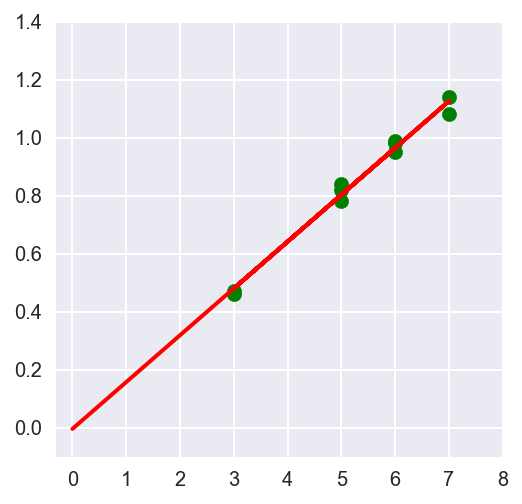

In [4]:
n_l = np.array([e['n_out'] for e in data])
q_l = np.array([e['q_out'] for e in data])
plot_data = np.vstack([n_l, q_l]).tolist()
sss.plot_res(plot_data)

最小二乘法 : Y = m * X + c, m = 0.161719, c = -0.005995 
相对误差 : U_r = 1.1%
e_m = 1.617*(1±1.1%)*10^(-19)


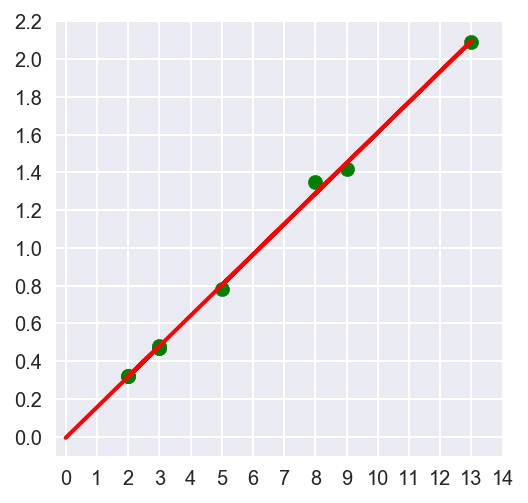

In [5]:
plotter = BOOM()
l = [[8.0, 13.0, 5.0, 9.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0],
     [1.35, 2.09, 0.78, 1.42, 0.32, 0.32, 0.48, 0.47, 0.32, 0.47]]
plotter.plot_res(l)

In [6]:
# 生成的数据:
data

[{'U': 126,
  'n': 7,
  'n_out': 7,
  'q_out': 1.08,
  't_bar': 15.3,
  't_l': [[15.6], [14.9], [15.5], [14.9], [15.8]],
  't_make': 14.9749615180029},
 {'U': 226,
  'n': 5,
  'n_out': 5,
  'q_out': 0.82,
  't_bar': 12.5,
  't_l': [[12.5], [12.8], [11.7], [12.5], [13.2]],
  't_make': 12.7734470268485},
 {'U': 219,
  'n': 3,
  'n_out': 3,
  'q_out': 0.46,
  't_bar': 18.6,
  't_l': [[19.4], [18.8], [18.8], [18.0], [18.2]],
  't_make': 18.0797273981712},
 {'U': 256,
  'n': 6,
  'n_out': 6,
  'q_out': 0.99,
  't_bar': 10.2,
  't_l': [[10.3], [9.7], [10.4], [10.0], [10.8]],
  't_make': 10.4834010602584},
 {'U': 210,
  'n': 3,
  'n_out': 3,
  'q_out': 0.47,
  't_bar': 18.7,
  't_l': [[18.0], [19.1], [19.2], [18.6], [18.8]],
  't_make': 18.5706746616522},
 {'U': 256,
  'n': 6,
  'n_out': 6,
  'q_out': 0.95,
  't_bar': 10.5,
  't_l': [[11.0], [10.3], [10.7], [10.5], [9.8]],
  't_make': 10.4834010602584},
 {'U': 126,
  'n': 5,
  'n_out': 5,
  'q_out': 0.78,
  't_bar': 18.9,
  't_l': [[19.4], [1

q	n
**********
0.419	 3
1.018	 6
0.432	 3
0.414	 3
0.625	 4
0.571	 4
0.639	 4
1.465	 9
0.959	 6
0.664	 4
最小二乘法 : Y = m * X + c, m = 0.168560, c = -0.049796 
相对误差 : U_r = 5.3%
e_m = 1.686*(1±5.3%)*10^(-19)


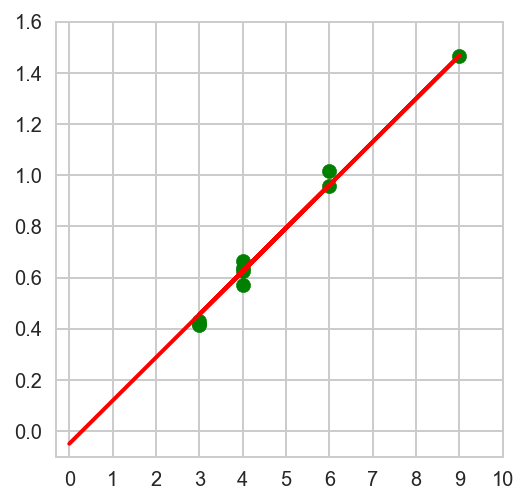

In [19]:
data = [[21.5,9.8,18.9,27.4,12.9,15.9,16.6,9.3,12.3,20.1],
        [191,268,227,132,285,225,188,202,200,134]]
sss = BOOM()
res = [[],[]]
print("q\tn\n**********")
for i in range(len(data[0])):
    q, n = sss.out(data[0][i], data[1][i])
    print("%.3f\t%2d" % (q, n))
    res[0].append(n)
    res[1].append(round(q, 3))
sss.plot_res(res)